<h1><center>Essential functions for stock charts technical analysis</center></h1> 

<h2><center>Moving Average (MA) + Bollinger Band + RSI</center></h2> 

In [172]:
# Fundamentals imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from adjustText import adjust_text

pd.set_option("display.precision", 3)

In [10]:
test_data = pd.read_csv("../Data/Stocks_data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")

---------------------------------------------------------------

<h1><center>Moving Average</center></h1> 

In [24]:
def calculate_ma(stocks_data, day_range = 14):
    '''
        Calculating Simple Moving Average based on the data frame and time period (which is set by the user). 
        Returns data frame with the "MA" column.

        Arguments:
            stocks_data - data frame with stocks data
            day_range - period on which Moving Average is calculated. By default - 14 (since it's considered a standard)
    '''
    
    moving_average = stocks_data['Close'].rolling(day_range).mean()
    stocks_data.loc[:, f'MA_{day_range}'] = moving_average

---------------------------------------------------------

<h1><center>Bollinger Band</center></h1> 

In [12]:
def calculate_bollinger_band(stocks_data, day_range = 14):
    '''
        Calculating Bollinger Bands Upper and Lower Bounds based on the stocks data dataframe.
        Returns a data frame with 2 new columns:
            1) BB_Upper_Bound
            2) BB_Lower_Bound

        Arguments:
            stocks_data - data frame with stocks data
            day_range - period on which Moving Average is calculated. By default - 14 (since it's considered a standard)
    '''
    if f"MA_{day_range}" not in stocks_data.columns:
        calculate_ma(stocks_data, day_range)
        
    ma = stocks_data[f"MA_{day_range}"]

    stocks_data["Standard Deviation"] = (stocks_data['Close'].rolling(window = day_range).std())
    standard_deviation = stocks_data["Standard Deviation"]
    stocks_data["BB_Upper_Bound"] = (ma + 2 * standard_deviation)
    stocks_data["BB_Lower_Bound"] = (ma - 2 * standard_deviation)
    

--------------------------------------------------------------------

<h1><center>Candlesticks graphic drawing</center></h1> 

In [13]:
def create_candles_graph(stocks_data, 
                         file_name = "Test-image", 
                         image_width = 100, 
                         image_height = 10, 
                         up_day_color = 'green', 
                         down_day_color = 'red',
                         days_range = 14,
                         save_to_file = False):

    '''
        Create a candlestick graphic of a given stocks data frame

        Arguments:
        
            Mandatory:
                stocks_data - data frame with stocks data
                
            Optional:
                image_width - Graphic image width in inches (by default 100)
                image_height -  Graphic image height in inches (by default 10)
                    Also user can customize up an down days color according to preferences:
                up_day_color - by default green
                down_day_color - by default - red
                
    '''
    
    fig, ax = plt.subplots(figsize = (image_width, image_height));
    ax.tick_params(axis = 'x', labelrotation = 45);
    columns_with_MA = [col for col in stocks_data.columns if f"MA" in col]
    if len(columns_with_MA) == 0:
        calculate_ma(stocks_data, 14)
    else:
        ax.plot(stocks_data["Date"], stocks_data[columns_with_MA[0]])

    for x, y in zip(stocks_data["Date"], stocks_data[columns_with_MA[0]]):
        plt.text(x, y, np.around(y, 2))

    ax.fill_between(stocks_data["Date"], stocks_data["BB_Upper_Bound"], stocks_data["BB_Lower_Bound"], 
                        color = "wheat",
                        interpolate = True,
                        edgecolor = ["coral", "fuchsia"],
                        linewidth = 2);
    
    up = stocks_data[stocks_data["Close"] > stocks_data["Open"]]
    down = stocks_data[stocks_data["Close"] < stocks_data["Open"]]
      
    ax.bar(up["Date"], up["Close"]-up["Open"], bottom=up["Open"], width =.2, color = up_day_color);
    ax.bar(up["Date"], up["High"] - up["Close"], bottom = up["Close"], width = .02, color = up_day_color);
    ax.bar(up["Date"], up["Low"] - up["Open"], bottom = up["Open"], width = .02, color = up_day_color);
    
    ax.bar(down["Date"], down["Close"] - down["Open"], bottom = down["Open"], width = .2, color = down_day_color);
    ax.bar(down["Date"], down["High"] - down["Open"], bottom = down["Open"], width = .02, color = down_day_color);
    ax.bar(down["Date"], down["Low"] - down["Close"], bottom = down["Close"], width = .02, color = down_day_color);

    plt.grid(True);
    
    if save_to_file:
        if file_name == '':
            file_name = "Candles_graph"
        re.sub('[^A-Za-z0-9]+', '', file_name)  
        fig.savefig(f"../{file_name}.png")

--------------------------------------------------------

<h1><center>Creating Plot with Moving average and Bollinger Bands</center></h1> 

In [14]:
def create_plot_with_MA_and_BB(df, 
                               amount_of_days_to_show = None, 
                               day_range = 14,
                               save_to_file = False,
                               file_name = ""):
    '''
        Creating a graphic with closing price + Moving average + Bollinger Bands

        Arguments:
            df - stocks data frame
            day_range - period range on which the data will be calculated. By default - 14
    '''
    if amount_of_days_to_show == None:
        amount_of_days_to_show = len(df)
        
    if amount_of_days_to_show <= len(df) and amount_of_days_to_show > 1:
        df = df.copy()[-amount_of_days_to_show :]
        
        calculate_bollinger_band(df, day_range)
     
        fig, ax = plt.subplots(figsize = (100, 10));
        
        ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 4);
        ax.plot(df["Date"], df["Close"], color = 'pink', linewidth = 5);
        df.dropna(inplace = True)
        ax.plot(df["Date"], df[f"MA_{day_range}"], color = 'red');
        
    
        ax.fill_between(df["Date"], df["BB_Upper_Bound"], df["BB_Lower_Bound"], 
                        interpolate = False,
                        color = "wheat",
                        edgecolor = ["coral", "fuchsia"],
                        linewidth = 4);
        
        ax.legend(["Close", "Moving average", "Bollinger Band"], loc = "upper right");
        plt.grid(True);
    if save_to_file:
        if file_name == "":
            file_name = "Stocks_data_with_MA_and_BB"

        

-----------------------------------------------------------------

<h1><center>Running MA + RSI</center></h1> 

In [15]:
def running_moving_average(df, range_in_days = 14):
    '''
        Calculates Running moving average. Returns moving average for the given period of time.

        Arguments:
            df - data frame with stocks data on which moving average will be calculated
            range_in_days - period on which Moving average will be calculated. By default - 14
    '''
    moving_average = np.full_like(df, np.nan)
    moving_average[range_in_days] = df[1: range_in_days + 1].mean()
    
    
    for i in range(range_in_days + 1, len(df)):
        moving_average[i] = (moving_average[i-1] * (range_in_days - 1) + df[i]) / range_in_days
    
    return moving_average

def calculate_rsi(stocks_data, range_in_days = 14):

    '''
        Calculating RSI and storing it in corresponding column in the given data frame.

        Arguments:
            stocks_data - data frame with stocks data where moving average must be calculated
            range_in_days - time period (in days) on which RSI is calculated. By default - 14
    '''
    
    close_price = stocks_data['Close']
    gain_and_loss = close_price.diff(1)
    is_gain, is_loss = gain_and_loss > 0, gain_and_loss < 0
    gain, loss = gain_and_loss, -gain_and_loss
    
    gain[is_loss] = 0
    loss[is_gain] = 0

    data = {"Gain" : gain, "Loss" : loss}
    
    stocks_data["Gain"] = gain
    stocks_data["Loss"] = loss
    stocks_data["AVG Gain"] = running_moving_average(stocks_data["Gain"].to_numpy(), range_in_days)
    stocks_data['AVG Loss'] = running_moving_average(stocks_data["Loss"].to_numpy(), range_in_days)

    stocks_data['RS'] = stocks_data["AVG Gain"] / stocks_data["AVG Loss"]

    stocks_data['RSI'] = 100 - (100/ (1 + stocks_data['RS']))

------------------------------------------------------------

<h1><center>ATR</center></h1> 

In [16]:
def calculate_atr(stocks_data, day_range = 14):
    '''
        Function that calculates ATR for the table with stocks data

        Arguments:
            stocks_data - data frame on which ATR should be calculated
            day_range - days range, on which ATR must be calculated (by default - 14)
    '''
    stocks_data["High vs Low"] = stocks_data["High"] - stocks_data["Low"]
    for i in range(1, len(stocks_data)):
        stocks_data.loc[i, "High Vs Yesterday Close"] = np.abs(stocks_data.loc[i, "High"] - stocks_data.loc[i - 1, "Close"])
        stocks_data.loc[i, "Low Vs Yesterday Close"] = np.abs(stocks_data.loc[i, "Low"] - stocks_data.loc[i - 1, "Close"])
        
    stocks_data["Max_TR"] = stocks_data[["High vs Low", "High Vs Yesterday Close", "Low Vs Yesterday Close"]].max(axis = 1)
    
    stocks_data.loc[13, "ATR"] =  stocks_data["Max_TR"][:14].sum() / 14
   
    for i in range(14, len(stocks_data)):
        stocks_data.loc[i, "ATR"] = (stocks_data.loc[i - 1, "ATR"] * (day_range - 1) + stocks_data.loc[i, "Max_TR"]) / day_range

    stocks_data.drop(columns = ["High vs Low", "High Vs Yesterday Close", "Low Vs Yesterday Close"], inplace = True)
    return stocks_data

-----------------------------------------------

<h1><center>Calculating all variables together:<center/> </h1>

In [17]:
def calculate_all_stocks_related_data(stocks_df, 
                                      bb_day_range = 14,
                                      atr_day_range = 14, 
                                      rsi_day_range = 14, ):
    '''
        Function that calculates and collects all stocks-related data:
            1) Bollinger bands
            2) ATR
            3) RSI

        Return:
            A data frame which have all related columns calculated inside it
            
        Arguments:
            1) stocks_df - pandas data frame on which we will be performing operations
            2) bb_day_range - amount of days to serve as range for bollinger bands. By default - 14
            3) atr_day_range - amount of days to serve as range for ATR. By default - 14
            4) rsi_day_range - amount of days to serve as range for RSI. By default - 14
    '''
    pd.set_option("display.precision", 3)
    calculate_bollinger_band(stocks_df, bb_day_range)
    calculate_atr(stocks_df, atr_day_range)
    calculate_rsi(stocks_df, rsi_day_range)     
    

In [197]:
def draw_RSI_line(stocks_data, days_range = 14):
    stocks_data = stocks_data.copy()
    if "RSI" not in stocks_data:
        calculate_rsi(stocks_data)
    fig, ax = plt.subplots(figsize = (90, 10));
    ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 20);
    stocks_data.dropna(inplace = True)
    plt.yticks(np.arange(np.round(min(stocks_data["RSI"])), np.round(max(stocks_data["RSI"])), 1.0))
    ax.plot(stocks_data["Date"], stocks_data["RSI"], marker = '.');
    plt.grid(True);
    plt.margins(y = 0.125)
    texts = []
    vertical = []
    for x, y in zip(stocks_data["Date"], stocks_data["RSI"]):
        rsi_value = plt.text(x, y, np.around(y, 2))
        rsi_value.set_fontsize('xx-large')
        texts.append(rsi_value)
        vertical.append(y)
        
    adjust_text(texts, target_y= vertical, force_static=(2,10), avoid_self=True)
    

In [198]:
test_data = pd.read_csv("../Data/Stocks_data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")

In [199]:
calculate_all_stocks_related_data(test_data)

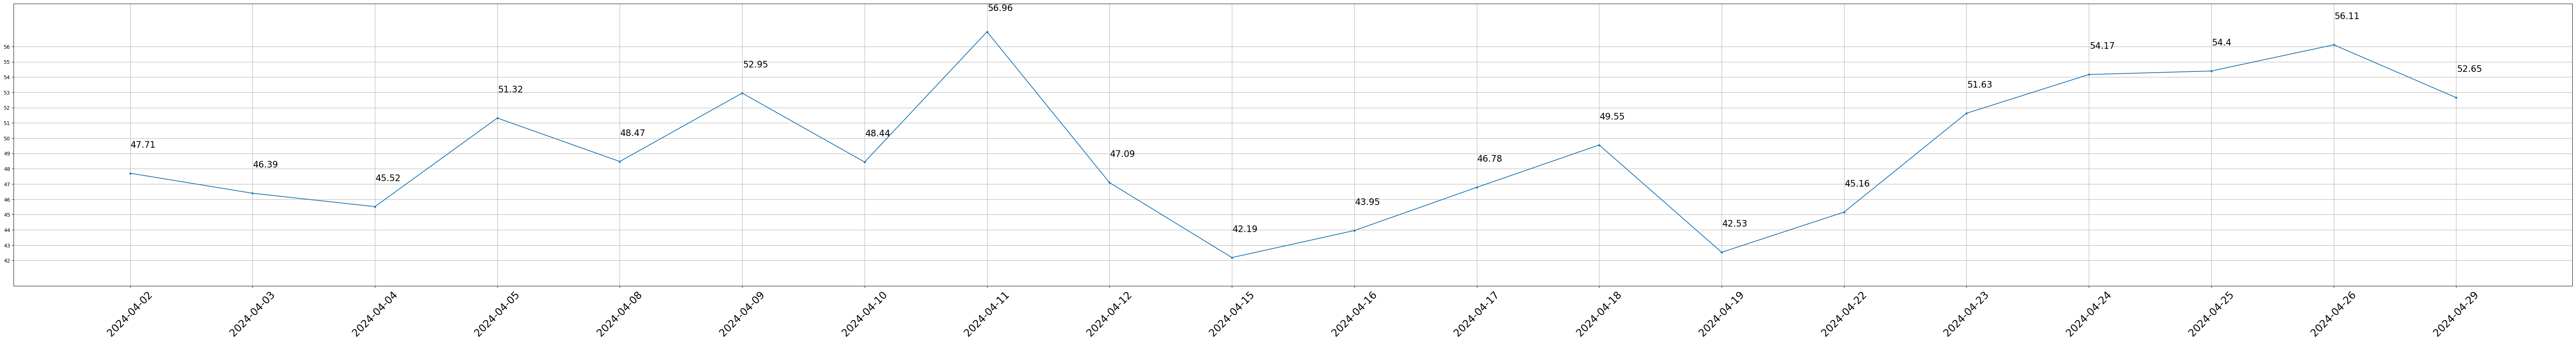

In [200]:
draw_RSI_line(test_data[-20:])